# Token-Sequence Prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import matplotlib.pyplot as plt
import seaborn as sns
import contextlib
from scipy.stats import skew, kurtosis
from scipy.spatial import distance
from statsmodels.tsa.stattools import acf, pacf
from collections import Counter
import matplotlib.pyplot as plt
from torchviz import make_dot

import gymnasium
from gymnasium import spaces
from copy import deepcopy
from typing import Any, ClassVar, Dict, List, Optional, Type, TypeVar, Union
import os

from stable_baselines3.common.distributions import CategoricalDistribution
from stable_baselines3.common.utils import constant_fn
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn, obs_as_tensor
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from sb3_contrib import RecurrentPPO
from sb3_contrib.common.recurrent.buffers import RecurrentDictRolloutBuffer, RecurrentRolloutBuffer
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib.common.recurrent.type_aliases import RNNStates
from stable_baselines3.common.policies import ActorCriticPolicy
from sb3_contrib.ppo_recurrent.policies import CnnLstmPolicy, MlpLstmPolicy, MultiInputLstmPolicy

#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$


Diverse Functions for data prep and visualisation

In [27]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=52, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

def kl_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # KL divergence
    kl_divergence = 0
    for token, p_real in real_probabilities.items():
        p_fake = fake_probabilities.get(token, 1e-10)  # Small value to avoid division by zero
        kl_divergence += p_real * np.log2(p_real / p_fake)
    
    return kl_divergence

def kl_jl(p_real, p_fake):

    kl_divergence = 0
    for token, p_r in p_real.items():
        p_f = p_fake.get(token, 1e-10)  # Add a small value to avoid division by zero
        kl_divergence += p_r * np.log2(p_r / p_f)
    return kl_divergence

def calculate_js_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # Average distribution M
    all_tokens = set(real_probabilities.keys()).union(set(fake_probabilities.keys()))
    average_probabilities = {token: 0.5 * (real_probabilities.get(token, 0) + fake_probabilities.get(token, 0)) for token in all_tokens}
    
    # KL divergence between real and average, and fake and average
    kl_real_to_avg = kl_jl(real_probabilities, average_probabilities)
    kl_fake_to_avg = kl_jl(fake_probabilities, average_probabilities)
    
    # Calculate JS divergence
    js_divergence = 0.5 * (kl_real_to_avg + kl_fake_to_avg)
    
    return js_divergence

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

def calculate_acf(trajectories, nlags=10):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags=10):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def print_sequences(real_prior, fake_prior, real_post, fake_post):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
    axs = axs.flatten()
    axs[0].plot(real_prior[0], color='lime', label='Real')
    axs[0].plot(fake_prior[0], color='crimson', label='Fake')
    axs[0].set_title('Sequence 1 Pre GAIL training')
    axs[0].set_ylim(0,40)
    axs[0].legend()
    axs[1].plot(real_prior[4], color='lime', label='Real')
    axs[1].plot(fake_prior[4], color='crimson', label='Fake')
    axs[1].set_title('Sequence 2 Pre GAIL training')
    axs[1].set_ylim(0,40)
    axs[1].legend()
    axs[2].plot(real_prior[9], color='lime', label='Real')
    axs[2].plot(fake_prior[9], color='crimson', label='Fake')
    axs[2].set_title('Sequence 3 Pre GAIL training')
    axs[2].set_ylim(0,40)
    axs[2].legend()
    axs[3].plot(real_post[0], color='lime', label='Real')
    axs[3].plot(fake_post[0], color='crimson', label='Fake')
    axs[3].set_title('Seq 1 Post GAIL training')
    axs[3].set_ylim(0,40)
    axs[3].legend()
    axs[4].plot(real_post[4], color='lime', label='Real')
    axs[4].plot(fake_post[4], color='crimson', label='Fake')
    axs[4].set_title('Seq 2 Post GAIL training')
    axs[4].set_ylim(0,40)
    axs[4].legend()
    axs[5].plot(real_post[9], color='lime', label='Real')
    axs[5].plot(fake_post[9], color='crimson', label='Fake')
    axs[5].set_title('Seq 3 Post GAIL training')
    axs[5].set_ylim(0,40)
    axs[5].legend()
    plt.tight_layout()
    plt.show()

def plot_training_metrics(metrics):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,6))
    axs = axs.flatten()
    axs[0].plot(metrics['loss'])
    axs[0].set_title('Loss')
    axs[1].plot(metrics['policy_gradient_loss'])
    axs[1].set_title('PGLoss')
    axs[2].plot(metrics['value_loss'])
    axs[2].set_title('Value Loss')
    axs[3].plot(metrics['entropy_loss'])
    axs[3].set_title('Entropy Loss')
    axs[4].plot(metrics['ep_rew_mean'])
    axs[4].set_title('Avg Sequence Reward')
    axs[5].plot(metrics['explained_variance'])
    axs[5].set_title('Explained Variance')
    axs[6].plot(metrics['approx_kl'])
    axs[6].set_title('KL Divergence')
    axs[7].plot(metrics['clip_fraction'])
    axs[7].set_title('Clip Fraction')
    plt.tight_layout()
    plt.show()

def plot_discr_perfomance(loss, prob_real, prob_fake):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    axs[0].plot(loss)
    axs[0].set_title('Discriminator Loss')
    axs[1].plot(prob_real, label='Real Sequences')
    axs[1].plot(prob_fake, label='Fake Sequences')
    axs[1].set_title('Avg probability')
    axs[1].set_ylim(0,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 52             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

Simulation of sample prices and their price deltas.

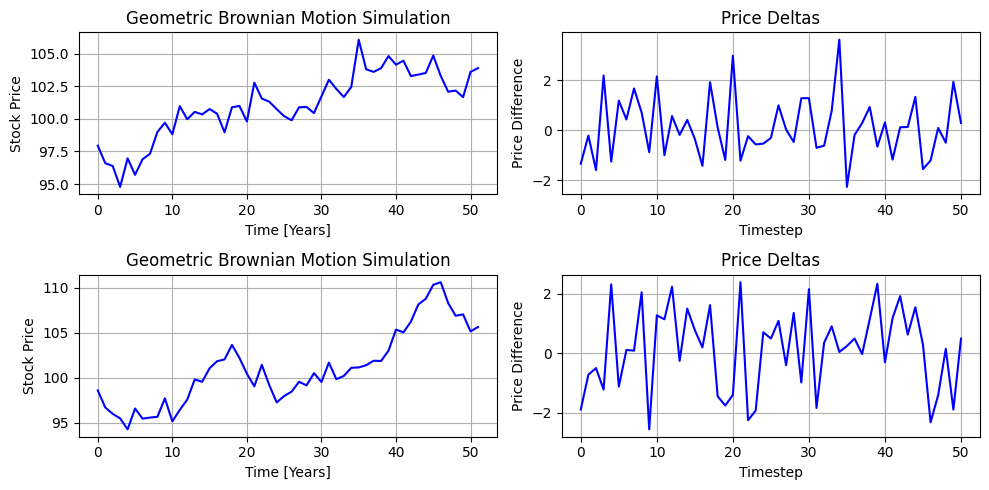

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].plot(Price_GBM[0], color='blue')
axs[0,0].set_title('Geometric Brownian Motion Simulation')
axs[0,0].set_xlabel('Time [Years]')
axs[0,0].set_ylabel('Stock Price')
axs[0,0].grid('True')

axs[0,1].plot(Delta_GBM[0], color='blue')
axs[0,1].set_title('Price Deltas')
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Price Difference')
axs[0,1].grid('True')

axs[1,0].plot(Price_GBM[5], color='blue')
axs[1,0].set_title('Geometric Brownian Motion Simulation')
axs[1,0].set_xlabel('Time [Years]')
axs[1,0].set_ylabel('Stock Price')
axs[1,0].grid('True')

axs[1,1].plot(Delta_GBM[5], color='blue')
axs[1,1].set_title('Price Deltas')
axs[1,1].set_xlabel('Timestep')
axs[1,1].set_ylabel('Price Difference')
axs[1,1].grid('True')
plt.tight_layout()
plt.show()

Saving the figures

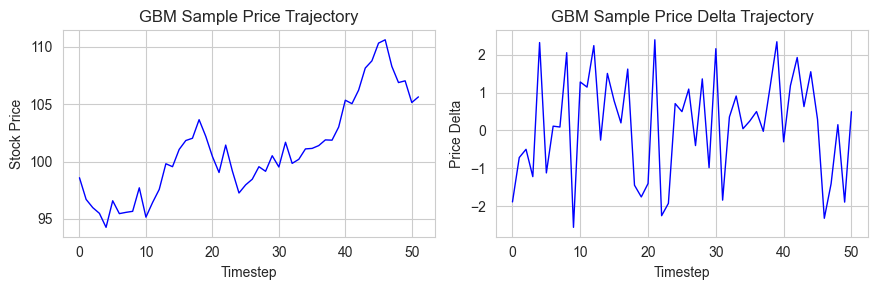

In [5]:
# Set style for grid and other elements
sns.set_style("whitegrid", sns.set_style("whitegrid", rc={"grid.alpha": 0.5}))
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(Price_GBM[5], color='blue', linewidth=1)
axs[0].set_title('GBM Sample Price Trajectory')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Stock Price')
axs[0].grid(True)
axs[1].plot(Delta_GBM[5], color='blue', linewidth=1)
axs[1].set_title('GBM Sample Price Delta Trajectory')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Delta')
axs[1].grid(True)
plt.tight_layout()
#plt.savefig('gbm_simulation.pdf', format='pdf', dpi=300)
plt.show()

##### Bin width and standard deviation of simulated price deltas

In [6]:
bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

Standard Deviation of Price Deltas: 1.276
BIN WIDTH:  0.3


##### Visualisations

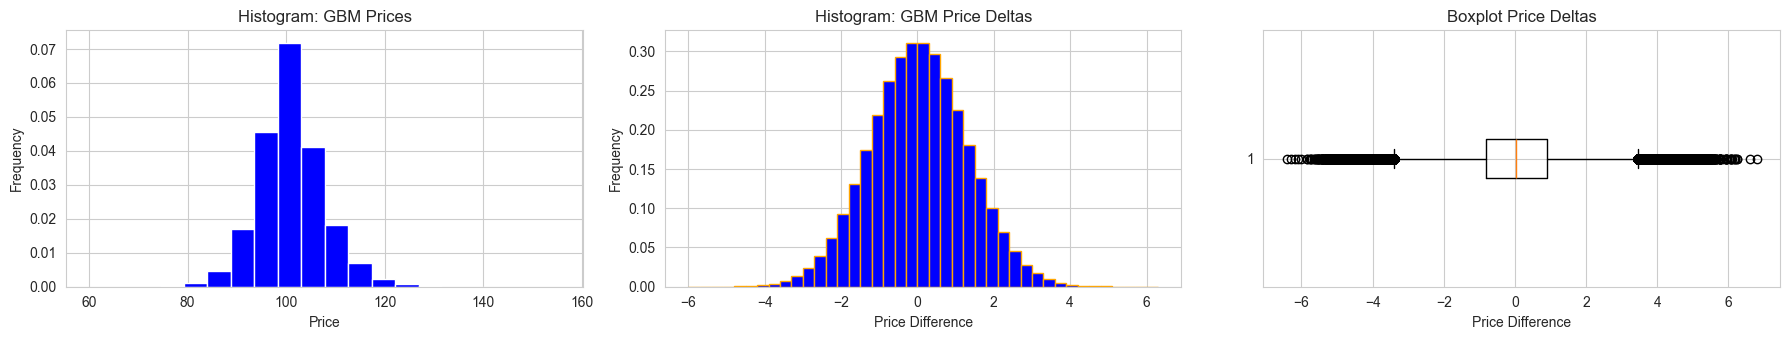

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM.flatten(), bins=20, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-6, 6 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM.flatten(), 
            bins=bins, 
            edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM.flatten(), vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Saving the Figure

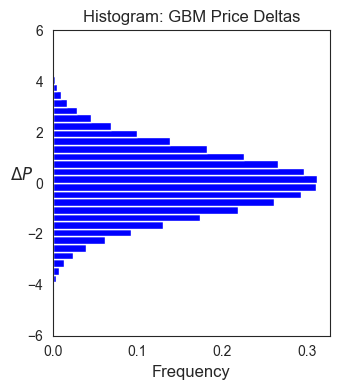

In [74]:
# Set Seaborn style without grid
sns.set_style("white")

# Define the bin width and range
bin_width = 0.3
bins = np.arange(-6, 6 + bin_width, bin_width)
plt.figure(figsize=(3.5,4))
# Plot the rotated histogram (90 degrees clockwise)
plt.hist(Delta_GBM.flatten(), 
         bins=bins, 
         edgecolor='white', 
         color='blue', 
         density=True, 
         orientation='horizontal')  # Rotate the histogram

# Set the title and axis labels with custom font sizes
plt.title('Histogram: GBM Price Deltas', fontsize=12)
plt.ylabel(r'$\Delta P$', fontsize=12, rotation=0)  # Rotating y-axis label for better readability
plt.xlabel('Frequency', fontsize=12)
plt.xlim(0, None)  # Optional: Ensure frequency starts from 0
plt.ylim(-6, 6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
#plt.savefig('tokenization.pdf', format='pdf', dpi=300)
plt.show()


In [8]:
train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-6.0, bin_stop=6.0, bin_width=bin_width)

Number of Tokens: 40
Training Data Shape: (30000, 51)
Validation Data Shape: (10000, 51)
Test Data Shape: (10000, 51)


LSTM Model

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer with 2 layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)  # Set num_layers=2
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # Embedding Layer
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim]
        # LSTM Layer (with 2 stacked layers)
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Shape: [batch_size, sequence_length, hidden_dim]
        # Apply Fully Connected Layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]

        return logits, (h_n, c_n)                               # Return predictions for each time step


#### Train setting:

| Train set:                           |     30'000  Sequences        |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |             
| **Batch size:**                      | **512**                      |


In [13]:
hidden_dim = 128                # Hidden Dimension
batch_size = 512                # Batch Size
learning_rate = 0.001           # LR
seq_len = len(train_data[0])    # Length of your tokenized sequences
num_epochs = 3                  # Number of epochs to train

LSTM TRAINING

In [14]:
model_SS = LSTMModel(vocab_size=token_size, embedding_dim=32, hidden_dim=hidden_dim, output_dim=token_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_SS.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

checkpoint_counter = 0

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============

    # Shuffle the data at the beginning of the epoch
    indices = np.arange(len(train_data))
    np.random.shuffle(indices)

    for batch_idx in range(0, len(train_data), batch_size):
        model_SS.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_data[batch_indices]
        
        inputs = torch.tensor(batch[:, :-1], dtype=torch.long)
        targets = torch.tensor(batch[:, 1:], dtype=torch.long)
        
        # Forward pass for this batch
        logits, _ = model_SS(inputs, None)
        logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
        
        loss = criterion(logits, targets)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters
        
        train_losses.append(loss.item())
        temp_train_loss.append(loss.item())
        
        ## ============
        ## VALIDATION
        ## ============
        
        model_SS.eval()
        with torch.no_grad():
            inputs = torch.tensor(val_data[:, :-1], dtype=torch.long)  # All tokens except the last
            targets = torch.tensor(val_data[:, 1:], dtype=torch.long)  # All tokens except the first
            logits, _ = model_SS(inputs, None)
            logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
            targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
            loss = criterion(logits, targets)
            val_losses.append(loss.item())
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            torch.save(model_SS.state_dict(), 'model_SS_best_weights.pth')
        
        if checkpoint_counter < 25:
            checkpoint_counter += 1
            torch.save(model_SS.state_dict(), f'ss_checkpoints/model_SS_episode{checkpoint_counter}.pth')
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

Epoch 1/3 - Train Loss: 3.0305 - Val Loss: 3.0183
Epoch 2/3 - Train Loss: 2.8791 - Val Loss: 2.8802
Epoch 3/3 - Train Loss: 2.8736 - Val Loss: 2.8747


Entropy of Validation Data: 2.87


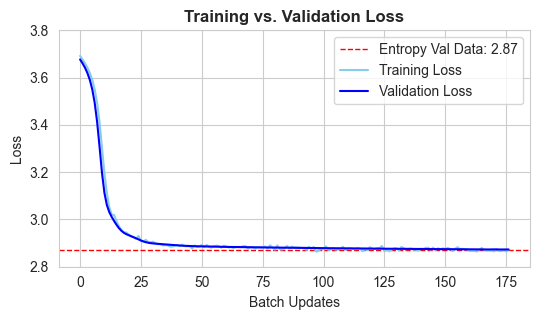

In [15]:
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

# Entropy calculation and display
entropy_val = round(calculate_entropy(val_data.flatten()), 3)
print('Entropy of Validation Data:', entropy_val)

# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.axhline(entropy_val, color='red', linestyle='--', linewidth=1, label=f'Entropy Val Data: {entropy_val}')
plt.plot(train_losses.flatten(), label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses.flatten(), label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.ylim(2.8,3.8)
plt.tight_layout()
#plt.savefig('train_loss_ss.pdf', format='pdf', dpi=300)
plt.show()

#### Evaluation and testing with teacher forcing

In [16]:
evaluation_model = LSTMModel(vocab_size=token_size, embedding_dim=32, hidden_dim=hidden_dim, output_dim=token_size)
evaluation_model.load_state_dict(torch.load('pretraining_best_weights.pth', weights_only=False))

val_loss = []
val_perplexity = []

test_loss = []
test_perplexity = []

evaluation_model.eval()
with torch.no_grad():
    
    # Validation Data
    for sequence in val_data:
        sequence_input = torch.tensor(sequence[:-1], dtype=torch.long).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:], dtype=torch.long).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49]
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)
    
    # Test Data
    for sequence in test_data:
        sequence_input = torch.tensor(sequence[:-1], dtype=torch.long).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:], dtype=torch.long).unsqueeze(0)           # Exclude first token
        logits, _ = evaluation_model(sequence_input, None)          # Forward pass
        logits = logits.view(-1, logits.size(-1))                   # Shape: [49, 27]
        targets = targets.view(-1)                                  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

Perplexity Score


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$

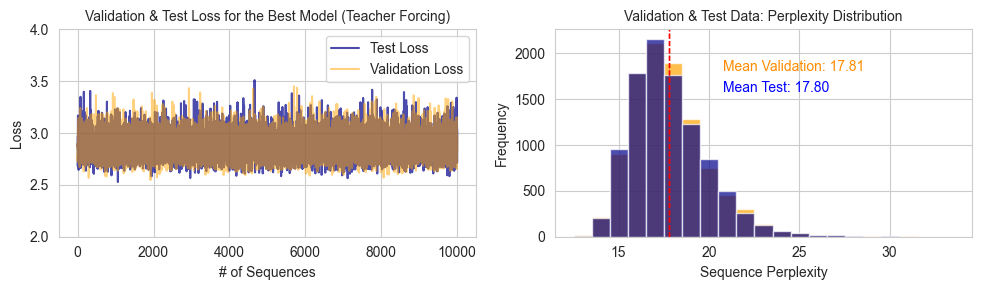

In [18]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

bin_start = min(np.min(val_perplexity), np.min(test_perplexity))
bin_stop = max(np.max(val_perplexity), np.max(test_perplexity))
bin_width = 1
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(test_loss, label='Test Loss', color='darkblue', alpha = 0.7)
axs[0].plot(val_loss, label='Validation Loss', color='orange', alpha = 0.5)
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(2,4)

# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=bin_edges, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=bin_edges, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
#axs[1].set_xlim(1,15)

#Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val+3.0, axs[1].get_ylim()[1] * 0.8, f'Mean Validation: {mean_val:.2f}', color='darkorange')
axs[1].text(mean_test+3.0, axs[1].get_ylim()[1] * 0.7, f'Mean Test: {mean_test:.2f}', color='blue')

plt.tight_layout()
plt.show()


#### Inference on test data

In [ ]:
test_losses = []
trajectories = []

evaluation_model.eval()
with torch.no_grad():

    for sequence in test_data:
    
        token_loss = 0

        # First real Token as start
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        # Initialize hidden and cell states to zero
        ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        hidden = (torch.zeros(2, 1, hidden_dim), torch.zeros(2, 1, hidden_dim))
        ##

        for i in range(1, len(sequence)):
            
            # Last value in Trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]], dtype=torch.long).unsqueeze(0)

            # Model prediction and hidden/cell states
            logits, hidden = evaluation_model(sequence_input, hidden)

            # Softmax
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            # Sample next Token
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            # Add to trajectory
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1).long()
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, true_token)
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)

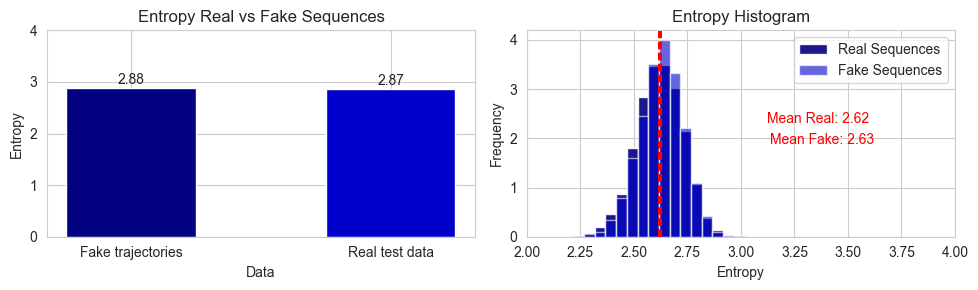

In [20]:
real_entropy = round(calculate_entropy(test_data.flatten()), 4)
fake_entropy = round(calculate_entropy(np.array(trajectories).flatten()), 4)

real_seq_entropy = []
fake_seq_entropy = []

for i in range(len(test_data)):
    real_seq_entropy.append(calculate_entropy(test_data[i][1:]))
    fake_seq_entropy.append(calculate_entropy(trajectories[i][1:]))

mean_real = np.mean(real_seq_entropy)
mean_fake = np.mean(fake_seq_entropy)

bin_start = min(np.min(real_seq_entropy), np.min(fake_seq_entropy))
bin_stop = max(np.max(real_seq_entropy), np.max(fake_seq_entropy))
bin_width = 0.05
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot Barplot
bars = axs[0].bar(x = ['Fake trajectories', 'Real test data'], height=[fake_entropy, real_entropy], width=0.5, color=['navy', 'mediumblue'])
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
axs[0].set_title('Entropy Real vs Fake Sequences')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Entropy')
axs[0].set_ylim(0, 4)

# Plot histograms
axs[1].hist(real_seq_entropy, bins=bin_edges, color='navy', alpha=0.9, label='Real Sequences', density=True)
axs[1].hist(fake_seq_entropy, bins=bin_edges, color='mediumblue', alpha=0.6, label='Fake Sequences', density=True)

# Plot vertical lines for means
axs[1].axvline(mean_real, color='red', linewidth=1.5, linestyle='dashed')
axs[1].axvline(mean_fake, color='red', linewidth=1.5, linestyle='dashed')
y_limit = axs[1].get_ylim()[1]
axs[1].text(mean_real + 0.502, y_limit * 0.55, f'Mean Real: {mean_real:.2f}', color='red')
axs[1].text(mean_fake + 0.51, y_limit * 0.45, f'Mean Fake: {mean_fake:.2f}', color='red')

# Set titles and labels
axs[1].set_title('Entropy Histogram')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(2,4)
axs[1].legend()

plt.tight_layout()
plt.show()


KL Divergence

$D_{KL}(P_{\text{real}} \parallel P_{\text{fake}}) = \sum_{i} p_{\text{real}}(x_i) \log \left( \frac{p_{\text{real}}(x_i)}{p_{\text{fake}}(x_i)} \right)$

Jensen-Shannon Divergence


$D_{JS}(P_{\text{real}} \parallel P_{\text{fake}}) = \frac{1}{2} D_{KL}(P_{\text{real}} \parallel M) + \frac{1}{2} D_{KL}(P_{\text{fake}} \parallel M)$, 

$\text{where } M = \frac{1}{2} (P_{\text{real}} + P_{\text{fake}})$


In [21]:
kl_div = round(kl_divergence(test_data.flatten(), np.array(trajectories).flatten()),4)
js_div = round(calculate_js_divergence(test_data.flatten(), np.array(trajectories).flatten()),4)

print("KL Divergence between Real and Fake Sequences (in bits):", kl_div)
print('')
print("JS Divergence between Real and Fake Sequences (in bits):", js_div)


KL Divergence between Real and Fake Sequences (in bits): 0.0016

JS Divergence between Real and Fake Sequences (in bits): 0.0005


#### Summary Statistics

In [23]:
# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(trajectories)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.3
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

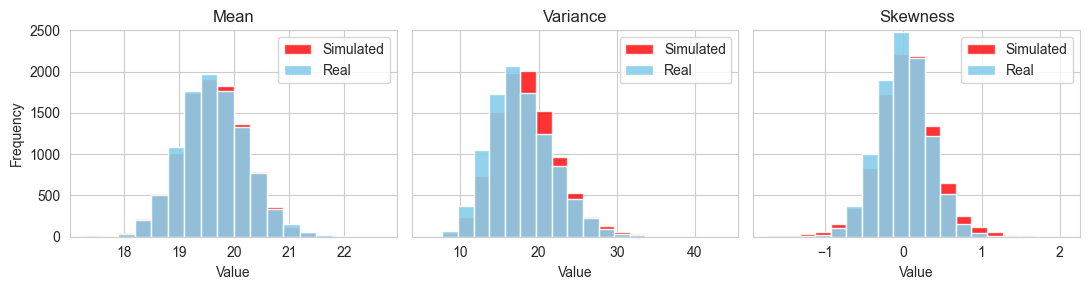

In [24]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,2500)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,2500)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,2500)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
#plt.savefig('ss_moments.pdf', format='pdf', dpi=300)
plt.show()

##### Trajectory comparison

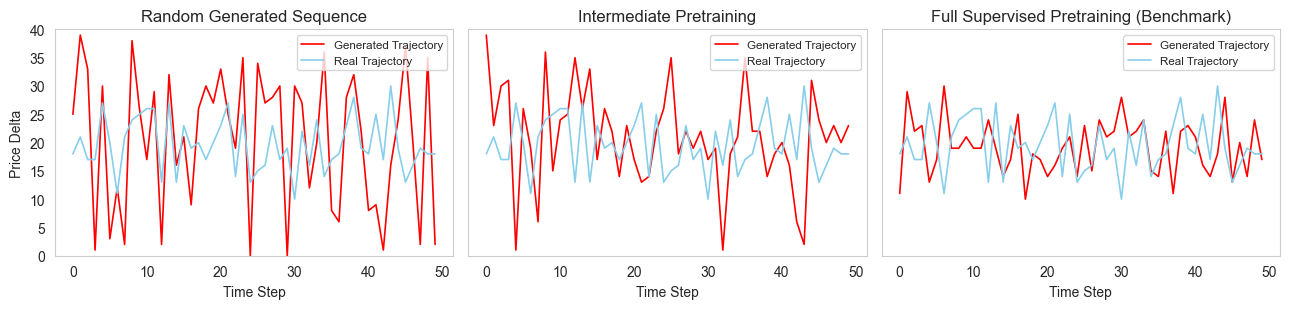

In [98]:
#random_traj = trajectories[100][1:]
#intermediate_traj = trajectories[100][1:]
#benchmark_traj = trajectories[100][1:]
#real_traj = test_data[100][1:]

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()


axes[0].plot(random_traj, label='Generated Trajectory', color='red', linewidth=1.2)
axes[0].plot(real_traj, label='Real Trajectory', color='skyblue', linewidth=1.2)
axes[0].grid(False)
axes[0].legend(loc='upper right', fontsize='small')
axes[0].set_ylabel('Price Delta')
axes[0].set_ylim(0, 40)
axes[0].set_xlabel('Time Step')
axes[0].set_title('Random Generated Sequence')

axes[1].plot(intermediate_traj, label='Generated Trajectory', color='red', linewidth=1.2)
axes[1].plot(real_traj, label='Real Trajectory', color='skyblue', linewidth=1.2)
axes[1].grid(False)
axes[1].legend(loc='upper right', fontsize='small')
axes[1].tick_params(labelleft=False) 
axes[1].set_ylim(0, 40)
axes[1].set_xlabel('Time Step')
axes[1].set_title('Intermediate Pretraining')

axes[2].plot(benchmark_traj, label='Generated Trajectory', color='red', linewidth=1.2)
axes[2].plot(real_traj, label='Real Trajectory', color='skyblue', linewidth=1.2)
axes[2].grid(False)
axes[2].legend(loc='upper right', fontsize='small')
axes[2].tick_params(labelleft=False) 
axes[2].set_ylim(0, 40)
axes[2].set_xlabel('Time Step')
axes[2].set_title('Full Supervised Pretraining (Benchmark)')
# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.savefig('pre_result.pdf', format='pdf', dpi=300)
plt.show()

##### Trajectory comparison: Real vs. Benchmark

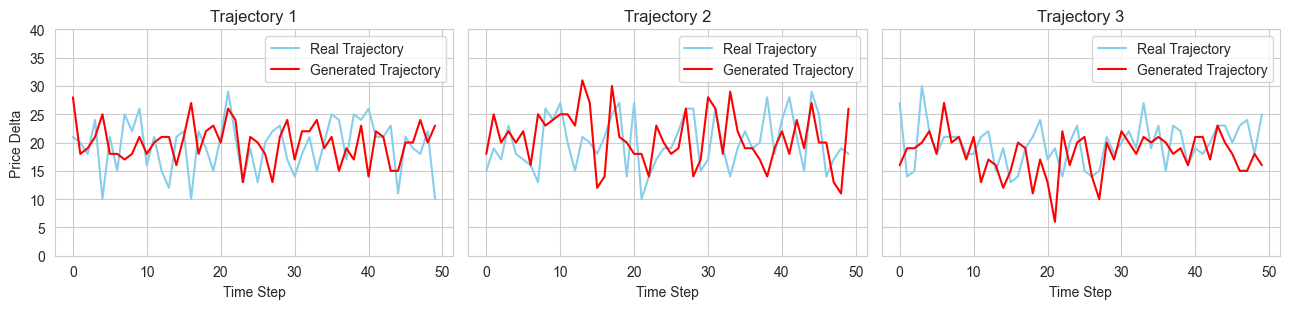

In [25]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(test_data[i+2012][1:], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(trajectories[i+2012][1:], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
#plt.savefig('ss_trajectory.pdf', format='pdf', dpi=300)
plt.show()

##### Autocorrelation

$ACF(k) = Corr(x_t, x_{t-k})$

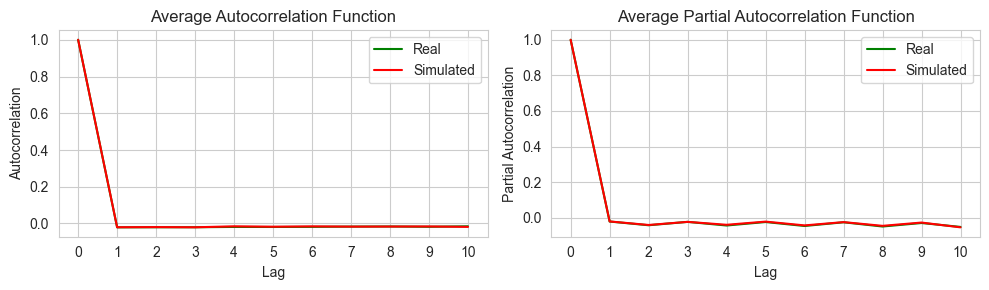

In [26]:
# ACFs for real and simulated trajectories
real_acfs = calculate_acf([test_data[i][1:] for i in range(len(test_data))])
simulated_acfs = calculate_acf([trajectories[i][1:] for i in range(len(trajectories))])
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf([test_data[i][1:] for i in range(len(test_data))])
simulated_pacfs = calculate_pacf([trajectories[i][1:] for i in range(len(trajectories))])
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xticks(np.arange(0, 11, 1))
axs[1].legend()

plt.tight_layout()
plt.show()


### GAIL implementation

**Policy Loss**

$L^{\text{CLIP}}(\theta) = -\mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \; \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]$
where, $r_t(\theta) = \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}$


**Value Loss**

$L_{\text{value}} = \frac{1}{N} \sum_{t=1}^{N} \left( V(s_t) - R_t \right)^2$


**Advantage Function**

$G_t = \sum_{k=0}^{T-1} \gamma^k r_{k}$

$A_t = \sum_{i=0}^{\infty} (\gamma \lambda)^i \delta_{t+i}$

$\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots$

where:

- $\gamma$ is the discount factor.
- $\lambda$ parameter that controls the bias-variance trade-off.
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.


##### Simple Discriminator LSTM Network with single output

In [33]:
class GAILDiscriminator(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GAILDiscriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)                         

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

##### Reinforcement Learning Environment

In [34]:
class TokenEnvironmentGAIL(gymnasium.Env):
    
    def __init__(self, train_data, val_data, test_data, sequence_length, training, num_bins, hidden_dim):
        
        super(TokenEnvironmentGAIL, self).__init__()

        self.first_reset = True
        self.num_bins = num_bins
        # Data
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.seq_len = sequence_length                                  # Sequence Length

        # FOR RESET
        self.training = training                                        # Training
        self.episode_counter = 0                                        # Counter
        self.episode_end = False                                        # End of Episode
        
        # Spaces
        self.action_space = spaces.Discrete(self.num_bins)             # Action Space
        self.observation_space = spaces.Discrete(self.num_bins)        # State Space

        ###============
        # DISCRIMINATOR
        ###============
        self.hidden_dim = hidden_dim
        self.discriminator = GAILDiscriminator(vocab_size=self.num_bins, embedding_dim=32, hidden_dim=self.hidden_dim)
        self.hidden_states_D = (torch.zeros(2, 1, self.hidden_dim), torch.zeros(2, 1, self.hidden_dim))
        self.real_sequences = []
        self.temp_fake = []
        self.fake_sequences = []

        self.discr_BCE_loss_single_seq = []
        self.discr_BCE_loss_all_seq = []

        self.discriminator_loss = []
        self.phi_real_prob = []
        self.phi_fake_prob = []

        self.discr_training = True

        # Loss function and Optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.D_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

        self.last_BCE_loss = nn.BCELoss()(torch.tensor(0.5), torch.tensor(0.))

        self.sequence_reward = 0
        self.manual_avg_reward = []

    def step(self, action):
        
        if isinstance(action, np.ndarray):
            action = action.item()
        
        assert self.action_space.contains(action), "Invalid Action"
        
        self.temp_fake.append(action)

        with torch.no_grad():
            discr_input = torch.tensor(action, dtype=torch.long).view(1, -1)
            discr_logit, self.hidden_states_D = self.discriminator.forward(x=discr_input, hidden=self.hidden_states_D)
            # BCE LOSS as Reward
            curr_BCE_loss = self.criterion(discr_logit, torch.zeros_like(discr_logit))
            curr_BCE_loss = curr_BCE_loss.item()

            self.discr_BCE_loss_single_seq.append(curr_BCE_loss)

        #print(f"Discriminator Mode: {'train' if self.discriminator.training else 'eval'}")

        ### ===============
        ###     REWARD
        ### ===============    

        reward = curr_BCE_loss - self.last_BCE_loss

        self.sequence_reward += reward

        ### ===============
        ###     REWARD
        ### ===============

        self.last_BCE_loss = curr_BCE_loss

        # Order matters!
        self.episode_counter += 1
        done = (self.episode_counter == (self.seq_len))
        
        if done:
            self.discr_BCE_loss_all_seq.append(self.discr_BCE_loss_single_seq)
            self.fake_sequences.append(np.array(self.temp_fake))
            
            self.manual_avg_reward.append(self.sequence_reward)
            self.sequence_reward = 0

        truncated = False
        info = {}

        next_state = action

        return next_state, reward, done, truncated, info

    def reset(self, seed=None, training=True, **kwargs):

        #print('ENV: RESET')

        if seed is not None:
            np.random.seed(seed)
        
        self.episode_counter = 0
        self.episode_end = False

        self.discriminator.eval()

        self.training = training
        
        if self.training:
            
            # Sample a Sequence from Train Data
            start_train_idx = np.random.choice(range(len(self.train_data)), size=1).item()

            train_sequence = self.train_data[start_train_idx]
            # First value of Sequence
            start_token = train_sequence[0]
            self.real_sequences.append(train_sequence)

        else:

            start_test_idx = np.random.choice(range(len(self.test_data)), size=1).item()
            test_sequence = self.test_data[start_test_idx]
            start_token = test_sequence[0]
            self.real_sequences.append(test_sequence)
        
        self.temp_fake = []
        self.temp_fake.append(start_token)

        # Discriminator implementation
        self.last_BCE_loss = nn.BCELoss()(torch.tensor(0.5), torch.tensor(0.))
        
        start_token = np.array([start_token])

        return start_token, {}
    
    def train_discriminator(self):

        print('AVERAGE REWARD PER SEQUENCE: ', np.mean(self.manual_avg_reward))
        self.manual_avg_reward = []

        self.discriminator.train()

        # Needed some adjustments
        real_seq = self.real_sequences[:-1]

        # Remove first Token
        batch_real = [torch.tensor(sequence[1:]) for sequence in real_seq]
        batch_real = torch.stack(batch_real)

        # Remove first Token
        batch_fake = [torch.tensor(sequence[1:]) for sequence in self.fake_sequences]
        batch_fake = torch.stack(batch_fake)
        
        ### CHECK BATCHES

        # print("")
        # print('BATCH REAL SHAPE: ', batch_real.shape)
        # print('BATCH REAL: ', batch_real)
        # print("")
        # print('BATCH FAKE SHAPE: ', batch_fake.shape)
        # print('BATCH FAKE: ', batch_fake)

        # 1. Train on real sequences (compare to 1, since 1 = real sequence)
        D_real_logits, _ = self.discriminator.forward(x=batch_real.long()) 
        final_logit_real = D_real_logits[:, -1]  # Final logit from last time step
        D_loss_real = self.criterion(final_logit_real, torch.ones_like(final_logit_real))
        
        final_prob_real = torch.sigmoid(final_logit_real)  # Sigmoid to get probabilities

        # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
        D_fake_logits, _ = self.discriminator.forward(x=batch_fake.long())
        final_logit_fake = D_fake_logits[:, -1]  # Final logit from last time step
        D_loss_fake = self.criterion(final_logit_fake, torch.zeros_like(final_logit_fake))
        
        final_prob_fake = torch.sigmoid(final_logit_fake)  # Sigmoid to get probabilities
        
        D_loss = (D_loss_real + D_loss_fake) / 2
        
        # print('Discrimintator Weight BEFORE')
        # for name, param in self.discriminator.named_parameters():
        #     if param.requires_grad:
        #         print(f"{name}: {param.data}")

        if self.discr_training:

            self.D_optimizer.zero_grad()
            D_loss.backward()
            self.D_optimizer.step()
            self.discr_training = False
            
        else:
            self.discr_training = True

        # print('Discrimintator Weight AFTER')
        # for name, param in self.discriminator.named_parameters():
        #     if param.requires_grad:
        #         print(f"{name}: {param.data}")

        self.discriminator_loss.append(D_loss.item())
        self.phi_real_prob.append(final_prob_real.mean().item())
        self.phi_fake_prob.append(final_prob_fake.mean().item())

        self.fake_sequences = []
        self.real_sequences = [np.array(self.real_sequences[-1])]
        
        self.discriminator.eval()

    def reset_discriminator_metrics(self):
        self.discriminator_loss = []
        self.phi_real_prob = []
        self.phi_fake_prob = []

    def get_discrimnator_result(self):
        return self.discriminator_loss, self.phi_real_prob, self.phi_fake_prob

    def get_sequences_inference(self):
        temp_real = self.real_sequences
        temp_fake = self.fake_sequences
        self.real_sequences = []
        self.fake_sequences = []
        return temp_real, temp_fake



##### Policy Class

In [35]:
class GAILPolicy(ActorCriticPolicy):
    
    def __init__(self, observation_space, action_space, lr_schedule, vocab_size, embedding_dim, hidden_dim, pretrained_weights, n_lstm_layers=2, *args, **kwargs):
        
        super(GAILPolicy, self).__init__(observation_space=observation_space, action_space=action_space, lr_schedule=lr_schedule, *args, **kwargs)
                
        ## LSTM Setup
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_lstm_layers, batch_first=True)
        self.fc_action = nn.Linear(hidden_dim, action_space.n)
        self.fc_value = nn.Linear(hidden_dim, 1)
        
        # Load pretrained weights
        if pretrained_weights:
            self.load_pretrained_weights(pretrained_weights)
        else:
            self.apply(self.init_weights)  # Apply initialization

        # Initialize the optimizer with custom parameters only
        self.optimizer = torch.optim.Adam(
            list(self.embedding.parameters()) + 
            list(self.lstm.parameters()) + 
            list(self.fc_action.parameters()) + 
            list(self.fc_value.parameters()), 
            lr=lr_schedule(1.0)
        )

        # Initialize the action distribution based on the action space
        self.action_dist = CategoricalDistribution(action_space.n)

    def forward(self, obs, lstm_states, episode_starts, deterministic=False):

        #print('POLICY: FORWARD')

        # Reset the hidden and cell state for a new sequence
        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()

        # Unpack the lstm_states for the actor and critic
        (hx, cx) = lstm_states.pi
        
        obs = obs.long()
        obs = obs.unsqueeze(0)
        x = self.embedding(obs)

        # Process through the shared LSTM
        lstm_out, (hx, cx) = self.lstm(x, (hx, cx))
        # Action Head
        action_logits = self.fc_action(lstm_out)
        # Detach LSTM output for critic to prevent gradient backpropagation through LSTM
        value = self.fc_value(lstm_out.detach())
        
        # Calculate actions and log probabilities
        action_dist = self._get_action_dist_from_latent(action_logits)
        actions = action_dist.get_actions(deterministic=deterministic)
        log_probs = action_dist.log_prob(actions)

        # Need to detach hidden states for value head
        updated_lstm_states = RNNStates(pi=(hx, cx), vf=(hx.detach(), cx.detach()))

        return actions, value, log_probs, updated_lstm_states
    
    def predict_values(self, obs, lstm_states_vf, episode_starts):
        
        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()
           lstm_states_vf = lstm_states.vf
        
        obs = obs.long()
        obs = obs.unsqueeze(0)
        x = self.embedding(obs)
        lstm_out, _ = self.lstm(x, lstm_states_vf)
        value = self.fc_value(lstm_out.detach())

        return value
    
    def evaluate_actions(self, obs, actions, lstm_states, episode_starts):

        obs = obs.long()
        x = self.embedding(obs)  # Embed the observations

        # Process through the shared LSTM
        lstm_out, _ = self.lstm(x)  # LSTM handles batch processing
         # Action head
        action_logits = self.fc_action(lstm_out)
        # Value head
        value = self.fc_value(lstm_out)
        #value = self.fc_value(lstm_out.detach())
        
        # Calculate action distribution
        action_dist = self._get_action_dist_from_latent(action_logits)
        log_probs = action_dist.log_prob(actions)  # Log probability for each action in the batch
        # Calculate entropy for exploration bonus
        entropy = action_dist.entropy()  # Entropy of the action distribution for each batch element

        value = value.view(-1)
        log_probs = log_probs.view(-1)
        entropy = entropy.view(-1)

        # Return values, log probabilities, and entropy
        return value, log_probs, entropy
    
    def predict(self, obs, lstm_state, deterministic=False):

        # Switch to eval mode (this affects batch norm / dropout)
        self.set_training_mode(False)
        
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.long).unsqueeze(0)
            x = self.embedding(obs)
            lstm_out, lstm_state = self.lstm(x, lstm_state)
            action_logits = self.fc_action(lstm_out)
            action_dist = self._get_action_dist_from_latent(action_logits)
            action = action_dist.get_actions(deterministic=deterministic)
            action = action.view(-1).numpy()

        return action, lstm_state

    def _get_action_dist_from_latent(self, latent_pi):

        return self.action_dist.proba_distribution(action_logits=latent_pi)

    def reset_recurrent_states(self):

        #print('POLICY: RESET STATES')

        hidden_shape = (self.lstm.num_layers, 1, self.lstm.hidden_size)
        hidden_state = torch.zeros(hidden_shape)
        cell_state = torch.zeros(hidden_shape)
        
        # Create separate hidden states for actor and critic    Shape [1, 1, 64]
        pi_states = (hidden_state.clone(), cell_state.clone())  # Actor states
        vf_states = (hidden_state.clone(), cell_state.clone())  # Critic states
        
        # RNNStates compatibility with RecurrentPPO
        return RNNStates(pi=pi_states, vf=vf_states)
    
    def load_pretrained_weights(self, pretrained_weigths_path):

        #print('POLICY: load_pretrained_weights')

        pretrained_dict = torch.load(pretrained_weigths_path, weights_only=False)
        # Embedding Layer
        if 'embedding.weight' in pretrained_dict:                                   
            self.embedding.weight.data.copy_(pretrained_dict['embedding.weight'])        
        # LSTM Layer
        for name, weights in self.lstm.named_parameters():
            if str('lstm.'+ name) in pretrained_dict:
                weights.data.copy_(pretrained_dict[str('lstm.'+ name)])
        # Action Head
        if 'fc.weight' in pretrained_dict and 'fc.bias' in pretrained_dict:
            self.fc_action.weight.data.copy_(pretrained_dict['fc.weight'])
            self.fc_action.bias.data.copy_(pretrained_dict['fc.bias'])

    def get_distribution(self, obs, lstm_states, episode_starts):

        if episode_starts.any():
           lstm_states = self.reset_recurrent_states()
        (hx, cx) = lstm_states.pi
        
        obs = torch.tensor(obs)
        obs = obs.long()
        obs = obs.unsqueeze(0)
        
        x = self.embedding(obs)
        lstm_out, (hx, cx) = self.lstm(x, (hx, cx))
        action_logits = self.fc_action(lstm_out)
        updated_lstm_states = RNNStates(pi=(hx, cx), vf=(hx.detach(), cx.detach()))

        return self._get_action_dist_from_latent(action_logits), updated_lstm_states

    def init_weights(self, m):
            if isinstance(m, nn.Linear):
                # Orthogonal initialization for Linear layers
                init.orthogonal_(m.weight, gain=1)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                # Orthogonal initialization for LSTM weights
                for name, param in m.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        init.orthogonal_(param.data, gain=1)
                    elif 'bias' in name:
                        init.constant_(param.data, 0)
    
    def _build(self, lr_schedule: Schedule):
        pass
        
    def _build_mlp_extractor(self) -> None:
        pass
    
    @staticmethod
    def _process_sequence(features, lstm_states, episode_starts, lstm):
        pass

    def _predict(self, observation, lstm_states, episode_starts, deterministic):

        pass

    

##### RecurrentPPO Class

In [38]:
SelfRecurrentPPO = TypeVar("SelfRecurrentPPO", bound="RecurrentPPO")

class RecurrentPPO_GAIL(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)
    with support for recurrent policies (LSTM).

    Based on the original Stable Baselines 3 implementation.

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: the verbosity level: 0 no output, 1 info, 2 debug
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpLstmPolicy": MlpLstmPolicy,
        "CnnLstmPolicy": CnnLstmPolicy,
        "MultiInputLstmPolicy": MultiInputLstmPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[RecurrentActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 128,
        batch_size: Optional[int] = 128,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[torch.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            seed=seed,
            device=device,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )

        # Initialize your class variables
        self.best_avg_reward = -float('inf')  # Best average reward
        self.policy_weights_path = "GAIL_best_weights.pth"
        
        # Custom
        self.sequence_len = env.seq_len
        self.training_metrics = {
        "entropy_loss": [],
        "policy_gradient_loss": [],
        "value_loss": [],
        "approx_kl": [],
        "clip_fraction": [],
        "loss": [],
        "explained_variance": [],
        "clip_range": [],
        "clip_range_vf": [],
        "n_updates": [],
        "ep_rew_mean": []
    }


        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl
        self._last_lstm_states = None

        if _init_setup_model:
            self._setup_model()

        self.discriminator_loss = []
        self.discriminator_prob_real = []
        self.discriminator_prob_fake = []

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)

        buffer_cls = RecurrentDictRolloutBuffer if isinstance(self.observation_space, spaces.Dict) else RecurrentRolloutBuffer

        self.policy = self.policy_class(
            self.observation_space,
            self.action_space,
            self.lr_schedule,
            use_sde=self.use_sde,
            **self.policy_kwargs,
        )
        self.policy = self.policy.to(self.device)

        # We assume that LSTM for the actor and the critic
        # have the same architecture
        lstm = self.policy.lstm

        # if not isinstance(self.policy, RecurrentActorCriticPolicy):
        #     raise ValueError("Policy must subclass RecurrentActorCriticPolicy")

        single_hidden_state_shape = (lstm.num_layers, self.n_envs, lstm.hidden_size)
        
        # hidden and cell states for actor and critic
        self._last_lstm_states = RNNStates(
            (
                torch.zeros(single_hidden_state_shape, device=self.device),
                torch.zeros(single_hidden_state_shape, device=self.device),
            ),
            (
                torch.zeros(single_hidden_state_shape, device=self.device),
                torch.zeros(single_hidden_state_shape, device=self.device),
            ),
        )

        hidden_state_buffer_shape = (self.n_steps, lstm.num_layers, self.n_envs, lstm.hidden_size)

        self.rollout_buffer = buffer_cls(
            self.n_steps,
            self.observation_space,
            self.action_space,
            hidden_state_buffer_shape,
            self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        rollout_buffer: RolloutBuffer,
        n_rollout_steps: int,
    ) -> bool:
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.

        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param rollout_buffer: Buffer to fill with rollouts
        :param n_steps: Number of experiences to collect per environment
        :return: True if function returned with at least `n_rollout_steps`
            collected, False if callback terminated rollout prematurely.
        """
        #print('COLLECT ROLLOUT')
        assert isinstance(
            rollout_buffer, (RecurrentRolloutBuffer, RecurrentDictRolloutBuffer)
        ), f"{rollout_buffer} doesn't support recurrent policy"

        assert self._last_obs is not None, "No previous observation was provided"
        # Switch to eval mode (this affects batch norm / dropout)
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()
        # Sample new weights for the state dependent exploration

        if self.use_sde:
            self.policy.reset_noise(env.num_envs)

        callback.on_rollout_start()

        lstm_states = deepcopy(self._last_lstm_states)

        while n_steps < n_rollout_steps:

            if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                # Sample a new noise matrix
                self.policy.reset_noise(env.num_envs)


            with torch.no_grad():
                # Convert to pytorch tensor or to TensorDict
                obs_tensor = obs_as_tensor(self._last_obs, self.device)
                episode_starts = torch.tensor(self._last_episode_starts, dtype=torch.float32, device=self.device)
                actions, values, log_probs, lstm_states = self.policy.forward(obs_tensor, lstm_states, episode_starts)

            actions = actions.cpu().numpy()
            # Rescale and perform action
            clipped_actions = actions
            # Clip the actions to avoid out of bound error
            if isinstance(self.action_space, spaces.Box):
                clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            ### RESET WILL BE CALLED HERE
            new_obs, rewards, dones, infos = env.step(clipped_actions)
            self.num_timesteps += env.num_envs

            # Give access to local variables
            callback.update_locals(locals())
            if not callback.on_step():
                return False

            self._update_info_buffer(infos, dones)
            n_steps += 1
            if isinstance(self.action_space, spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstraping with value function
            # see GitHub issue #633
            for idx, done_ in enumerate(dones):
                if (
                    done_
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with torch.no_grad():
                        terminal_lstm_state = (
                            lstm_states.vf[0][:, idx : idx + 1, :].contiguous(),
                            lstm_states.vf[1][:, idx : idx + 1, :].contiguous(),
                        )
                        # terminal_lstm_state = None
                        episode_starts = torch.tensor([False], dtype=torch.float32, device=self.device)
                        terminal_value = self.policy.predict_values(terminal_obs, terminal_lstm_state, episode_starts)[0]
                    rewards[idx] += self.gamma * terminal_value
            rollout_buffer.add(
                self._last_obs,                         # Observation
                actions,
                rewards,
                self._last_episode_starts,              # Episode start
                values,
                log_probs,
                lstm_states=self._last_lstm_states,     # LSTM Start
            )
            
            self._last_obs = new_obs
            self._last_episode_starts = dones
            ### WHEN IMPLEMENTING GAIL NEED TO ADJUST THIS
            if dones:
                self._last_lstm_states = self.policy.reset_recurrent_states()
            else:
                self._last_lstm_states = lstm_states
        with torch.no_grad():
            # Compute value for the last timestep
            episode_starts = torch.tensor(dones, dtype=torch.float32, device=self.device)
            values = self.policy.predict_values(obs_as_tensor(new_obs, self.device), lstm_states.vf, episode_starts)

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        ### WHEN IMPLEMENTING GAIL NEED TO ADJUST THIS
        self.training_metrics["ep_rew_mean"].append(np.mean(rollout_buffer.rewards)*self.sequence_len)

        callback.on_rollout_end()

        # After training, compare the average reward and save weights if improved
        avg_reward = np.mean(env.envs[0].manual_avg_reward)

        # Save best policy
        if avg_reward > self.best_avg_reward:
            self.best_avg_reward = avg_reward
            print(f"New best average reward: {self.best_avg_reward}, saving policy weights...")
            torch.save(self.policy.state_dict(), self.policy_weights_path)
        
        ##===================###
        # Discriminator Training
        ###===================###
        env.envs[0].train_discriminator()
        disc_loss, disc_prob_real, disc_prob_fake = env.envs[0].get_discrimnator_result()
        self.discriminator_loss.append(disc_loss)
        self.discriminator_prob_real.append(disc_prob_real)
        self.discriminator_prob_fake.append(disc_prob_fake)
        env.envs[0].reset_discriminator_metrics()
        ###===================###
        # Discriminator Training
        ###===================###
    
        return True

    def get_sequences_from_rollout(self):

        rollout_data = self.rollout_buffer
        sequence_length = self.sequence_len

        sequences = []

        current_sequence = {'observations': [], 'actions': [], 'rewards': [], 'episode_starts': [], 
                            'old_values': [], 'old_log_probs': [], 'advantages': [], 'returns': []}

        for i in range(len(rollout_data.observations)):
            # Check if it's the start of a new sequence
            if rollout_data.episode_starts[i] == 1.0:
                # If there's an existing sequence, add it to the list
                if len(current_sequence['observations']) == sequence_length:
                    sequences.append(current_sequence)
                # Start a new sequence
                current_sequence = {'observations': [], 'actions': [], 'rewards': [], 'episode_starts': [], 
                                    'old_values': [], 'old_log_probs': [], 'advantages': [], 'returns': []}

            # Add data to the current sequence
            current_sequence['observations'].append(rollout_data.observations[i].item())
            current_sequence['actions'].append(rollout_data.actions[i].item())
            current_sequence['rewards'].append(rollout_data.rewards[i].item())
            current_sequence['episode_starts'].append(rollout_data.episode_starts[i].item())
            current_sequence['old_values'].append(rollout_data.values[i].item())
            current_sequence['old_log_probs'].append(rollout_data.log_probs[i].item())
            current_sequence['advantages'].append(rollout_data.advantages[i].item())
            current_sequence['returns'].append(rollout_data.returns[i].item())

        # Add the last sequence if it reaches the desired length
        if len(current_sequence['observations']) == sequence_length:
            sequences.append(current_sequence)
        
        for sequence in sequences:
        # Convert sequence data to tensors
            sequence['observations'] = torch.tensor(sequence['observations'], dtype=torch.float32).view(1, -1)
            sequence['actions'] = torch.tensor([int(action) for action in sequence['actions']], dtype=torch.long).view(1, -1)
            sequence['rewards'] = torch.tensor(sequence['rewards'], dtype=torch.float32).view(1, -1)
            sequence['episode_starts'] = torch.tensor(sequence['episode_starts'], dtype=torch.float32).view(1, -1)
            sequence['old_values'] = torch.tensor(sequence['old_values'], dtype=torch.float32).view(-1)
            sequence['old_log_probs'] = torch.tensor(sequence['old_log_probs'], dtype=torch.float32).view(-1)
            sequence['advantages'] = torch.tensor(sequence['advantages'], dtype=torch.float32).view(-1)
            sequence['returns'] = torch.tensor(sequence['returns'], dtype=torch.float32).view(-1)

        return sequences

    def print_sequences(self, sequences):
        # Iterate over each sequence
        for seq_idx, sequence in enumerate(sequences):
            print(f"\n--- Sequence {seq_idx + 1} ---\n")
            print(f"  Observation: {sequence['observations']}")
            print(f"  Action: {sequence['actions']}")
            print(f"  Reward: {sequence['rewards']}")
            print(f"  Episode Start: {sequence['episode_starts']}")
            print(f"  Values: {sequence['old_values']}")
            print(f"  Log Probabilities: {sequence['old_log_probs']}")
            print(f"  Advantages: {sequence['advantages']}")
            print(f"  Returns: {sequence['returns']}")
            print("\n--- End of Sequence ---\n")

    def data_prep_train(self) -> None:

        rollout_data = self.rollout_buffer

        for i, (obs, action, reward, ep_start, value, log_probs, advantages, ret) in enumerate(zip(
            rollout_data.observations,
            rollout_data.actions,
            rollout_data.rewards,
            rollout_data.episode_starts,
            rollout_data.values,
            rollout_data.log_probs,
            rollout_data.advantages,
            rollout_data.returns
        )): 
            if ep_start:
                print("---- New Sequence Start ----")
            print(f"Step {i}: Observation: {obs}, Action: {action}, Reward: {reward}, Episode Start: {ep_start}, Values: {value}, Log Probs: {log_probs} Advantages: {advantages}, Returns: {ret}")
                    
    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        """
        #print("START TRAINING")
        #self.data_prep_train()
        
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []
        saved_loss_all_seq = []

        continue_training = True

        # CUSTOM
        sequences = self.get_sequences_from_rollout()

        #self.print_sequences(sequences)

        for epoch in range(self.n_epochs):

            loss_list = []
            approx_kl_divs = []
            
            for sequence in sequences:

                actions = sequence['actions'].long().flatten()

                values, log_prob, entropy = self.policy.evaluate_actions(
                    obs=sequence['observations'],
                    actions=actions,
                    lstm_states=None,
                    episode_starts=None
                )

                # Advantage
                advantages = sequence['advantages']
                if self.normalize_advantage:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # ratio between old and new policy, should be one at the first iteration
                ratio = torch.exp(log_prob - sequence['old_log_probs'])
                
                 # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -torch.mean(torch.min(policy_loss_1, policy_loss_2))

                # PG LOSS APPEND
                pg_losses.append(policy_loss.item())
                
                clip_fraction = torch.mean((torch.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                # We have None in our case!
                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the different between old and new value
                    # NOTE: this depends on the reward scaling
                    
                    values_pred = sequence['old_values'] + torch.clamp(
                        values - sequence['old_values'], -clip_range_vf, clip_range_vf
                    )
                
                # Value loss using the TD(gae_lambda) target
                value_loss = torch.mean(((sequence['returns'] - values_pred) ** 2))
                
                # VALUE LOSS APPEND
                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -torch.mean(-log_prob)
                else:
                    entropy_loss = -torch.mean(entropy)

                # ENTROPY LOSS APPEND
                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss
                loss_list.append(loss)
                saved_loss_all_seq.append(loss.item())

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with torch.no_grad():
                    log_ratio = log_prob - sequence['old_log_probs']
                    approx_kl_div = torch.mean(((torch.exp(log_ratio) - 1) - log_ratio)).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)
                
                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break
    
            if not continue_training:
                break
            
            ##===================###
            # Policy Training
            ###===================###

            # Perform optimization step only after all sequences have been processed
            self.policy.optimizer.zero_grad()  # Clear gradients
            total_loss = torch.mean(torch.stack(loss_list))
            total_loss.backward()  # Backpropagate accumulated loss
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)  # Clip gradients

            # print('Policy Weight BEFORE')
            # for name, param in self.policy.named_parameters():
            #     if param.requires_grad:
            #         print(f"{name}: {param.data}")
            
            self.policy.optimizer.step()  # Update the policy weights

            # print('')
            # print('Policy Weight AFTER')
            # for name, param in self.policy.named_parameters():
            #     if param.requires_grad:
            #         print(f"{name}: {param.data}")
            
            ##===================###
            # Policy Training
            ###===================###

        self._n_updates += self.n_epochs
        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", np.mean(saved_loss_all_seq))
        self.logger.record("train/explained_variance", explained_var)
        
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", torch.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)
        
        # Add after calculating metrics
        self.training_metrics["entropy_loss"].append(np.mean(entropy_losses))
        self.training_metrics["policy_gradient_loss"].append(np.mean(pg_losses))
        self.training_metrics["value_loss"].append(np.mean(value_losses))
        self.training_metrics["approx_kl"].append(np.mean(approx_kl_divs))
        self.training_metrics["clip_fraction"].append(np.mean(clip_fractions))
        self.training_metrics["loss"].append(loss.item())
        self.training_metrics["explained_variance"].append(explained_var)
        self.training_metrics["n_updates"].append(self._n_updates)
        self.training_metrics["clip_range"].append(clip_range)
        
        if self.clip_range_vf is not None:
            self.training_metrics["clip_range_vf"].append(clip_range_vf)

    def learn(
        self: SelfRecurrentPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "RecurrentPPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfRecurrentPPO:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

    def _excluded_save_params(self) -> List[str]:
        return super()._excluded_save_params() + ["_last_lstm_states"]  # noqa: RUF005



##### Setup the GAIL model

In [39]:
# Define a function to return a constant learning rate
lr_schedule = constant_fn(1e-4)

model_GAIL = RecurrentPPO_GAIL(
    policy=GAILPolicy,
    env=TokenEnvironmentGAIL(train_data=train_data, val_data=val_data, test_data=test_data, sequence_length=50, training=True, num_bins=token_size, hidden_dim=hidden_dim),
    # Batch Size is 64
    n_steps=50*64,
    n_epochs=10,
    policy_kwargs=dict(
        vocab_size=token_size,
        embedding_dim=32,
        hidden_dim=hidden_dim,
        pretrained_weights=None
    ),
    learning_rate=lr_schedule,
    verbose=0
)

##### GAIL training

In [40]:
model_GAIL.learn(total_timesteps=150000)

disc_loss = np.array(model_GAIL.discriminator_loss).flatten()
disc_prob_real = np.array(model_GAIL.discriminator_prob_real).flatten()
disc_prob_fake = np.array(model_GAIL.discriminator_prob_fake).flatten()

New best average reward: -0.03887373208999634, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.038873732
New best average reward: -0.038491133600473404, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.038491134
New best average reward: -0.0362233966588974, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.036223397
New best average reward: -0.03574925661087036, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.035749257
New best average reward: -0.03292417526245117, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.032924175
New best average reward: -0.032446540892124176, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.03244654
New best average reward: -0.030485644936561584, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.030485645
New best average reward: -0.028986480087041855, saving policy weights...
AVERAGE REWARD PER SEQUENCE:  -0.02898648
New best average reward: -0.01813996396958828, saving policy weights...
AVERAGE

##### Visualisations

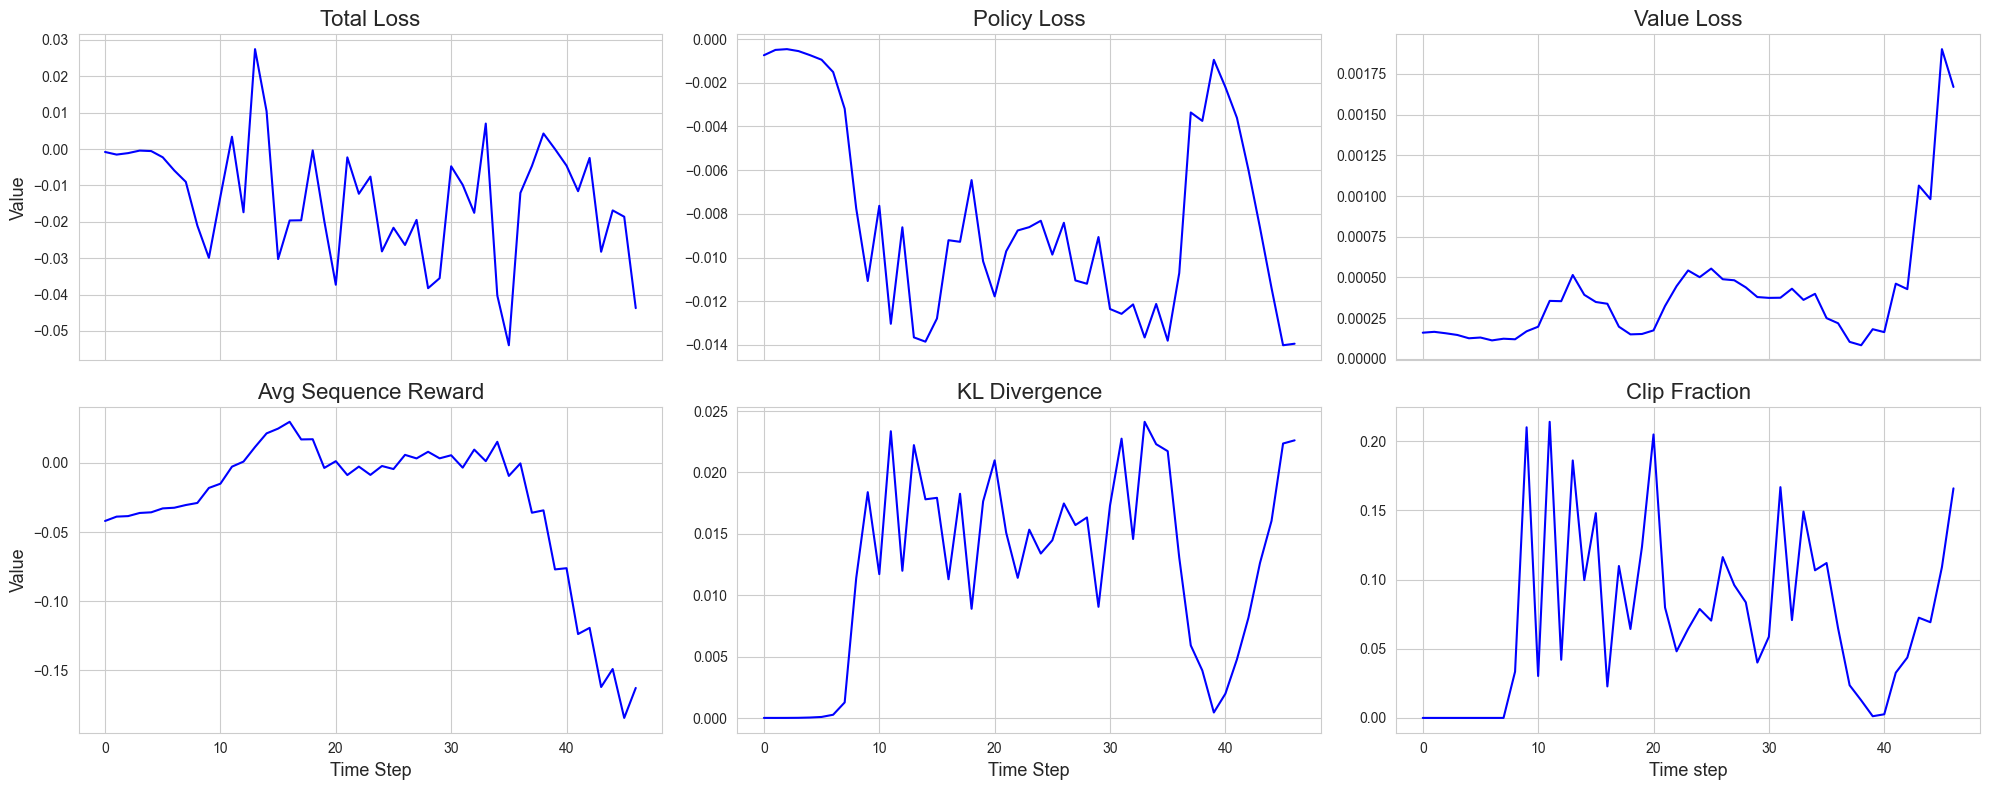

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs = axs.flatten()
axs[0].plot(model_GAIL.training_metrics['loss'], color = 'blue')
axs[0].set_title('Total Loss', fontsize=16)
axs[0].tick_params(labelbottom=False)
axs[0].set_ylabel('Value', fontsize = 13)
axs[1].plot(model_GAIL.training_metrics['policy_gradient_loss'], color = 'blue')
axs[1].set_title('Policy Loss', fontsize=16)
axs[1].tick_params(labelbottom=False)
axs[2].plot(model_GAIL.training_metrics['value_loss'], color = 'blue')
axs[2].set_title('Value Loss', fontsize=16)
axs[2].tick_params(labelbottom=False)
axs[3].plot(model_GAIL.training_metrics['ep_rew_mean'], color = 'blue')
axs[3].set_title('Avg Sequence Reward', fontsize=16)
axs[3].set_ylabel('Value', fontsize=13)
axs[3].set_xlabel('Time Step', fontsize=13)
axs[4].plot(model_GAIL.training_metrics['approx_kl'], color = 'blue')
axs[4].set_title('KL Divergence', fontsize=16)
axs[4].set_xlabel('Time Step', fontsize=13)
axs[5].plot(model_GAIL.training_metrics['clip_fraction'], color = 'blue')
axs[5].set_title('Clip Fraction', fontsize=16)
axs[5].set_xlabel('Time step', fontsize=13)
plt.tight_layout()
#plt.savefig('policy_random_training.pdf', format='pdf', dpi=300)
plt.show()

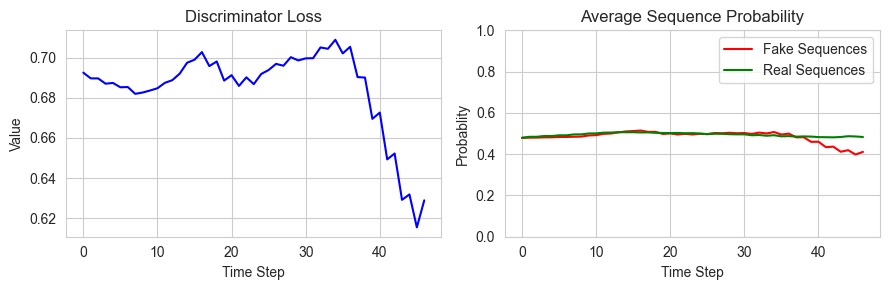

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
axs[1].plot(disc_prob_fake, label='Fake Sequences', color = 'red')
axs[1].plot(disc_prob_real, label='Real Sequences', color = 'green')
axs[1].set_title('Average Sequence Probability')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Probablity')
axs[0].plot(disc_loss, color = 'blue')
axs[0].set_title('Discriminator Loss')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Value')

plt.legend()
plt.tight_layout()
plt.savefig('discriminator_random_training.pdf', format='pdf', dpi=300)
plt.show()

Get the weights of the LSTM and Actor head

In [ ]:
state_dict = torch.load('GAIL_best_weights.pth')
# Rename 'fc_action' to 'fc'
state_dict['fc.weight'] = state_dict.pop('fc_action.weight')
state_dict['fc.bias'] = state_dict.pop('fc_action.bias')
# Remove 'fc_value' weights
state_dict.pop('fc_value.weight', None)
state_dict.pop('fc_value.bias', None)
# Save the updated state dict if needed
torch.save(state_dict, 'GAIL_best_weights.pth')

In [45]:
random_model = LSTMModel(vocab_size=token_size, embedding_dim=32, hidden_dim=hidden_dim, output_dim=token_size)

pretrain_model = LSTMModel(vocab_size=token_size, embedding_dim=32, hidden_dim=hidden_dim, output_dim=token_size)
pretrain_model.load_state_dict(torch.load('pretraining_best_weights.pth', weights_only=False))

gail_model = LSTMModel(vocab_size=token_size, embedding_dim=32, hidden_dim=hidden_dim, output_dim=token_size)
gail_model.load_state_dict(torch.load('GAIL_best_weights.pth', weights_only=False))


<All keys matched successfully>

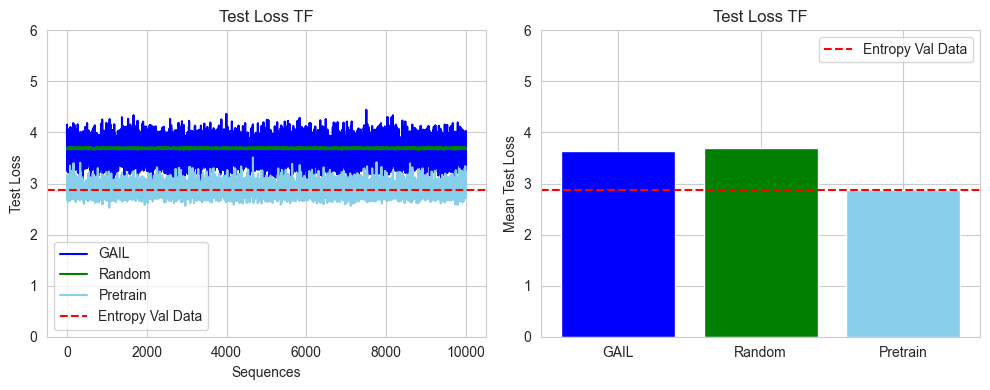

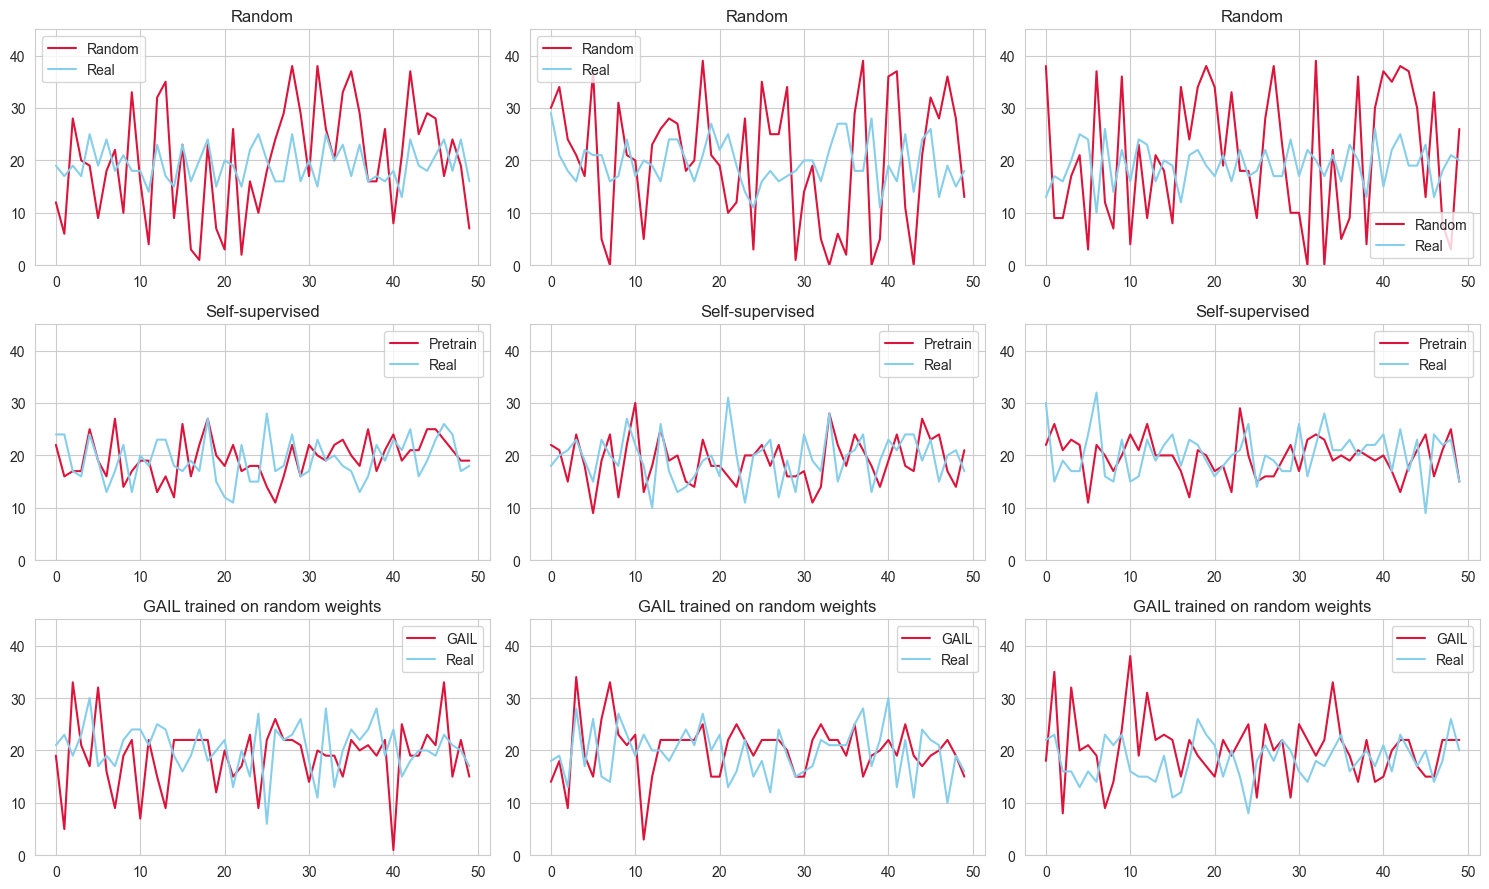

In [46]:
criterion = nn.CrossEntropyLoss()
random_model.eval()
pretrain_model.eval()
gail_model.eval()

val_loss_random = []
val_loss_pretrain = []
val_loss_gail = []

test_loss_random = []
test_loss_pretrain = []
test_loss_gail = []

with torch.no_grad():

    # for sequence in val_data:
    #     sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   
    #     targets = torch.tensor(sequence[1:]).unsqueeze(0)           

    #     # Random model
    #     logits, _ = random_model(sequence_input.long(), None)              
    #     logits = logits.view(-1, logits.size(-1))                   
    #     targets = targets.view(-1).long()                                  
    #     loss = criterion(logits, targets)
    #     val_loss_random.append(loss.item())

    #     # Pretrain Self Supervised
    #     logits, _ = pretrain_model(sequence_input.long(), None)            
    #     logits = logits.view(-1, logits.size(-1))                   
    #     targets = targets.view(-1).long()                             
    #     loss = criterion(logits, targets)
    #     val_loss_pretrain.append(loss.item())

    #     # After GAIL
    #     logits, _ = gail_model(sequence_input.long(), None)              
    #     logits = logits.view(-1, logits.size(-1))                   
    #     targets = targets.view(-1).long()                 
    #     loss = criterion(logits, targets)
    #     val_loss_gail.append(loss.item())

    for sequence in test_data:
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   
        targets = torch.tensor(sequence[1:]).unsqueeze(0)      

        # Random model
        logits, _ = random_model(sequence_input.long(), None)              
        logits = logits.view(-1, logits.size(-1))                   
        targets = targets.view(-1).long()                                 
        loss = criterion(logits, targets)
        test_loss_random.append(loss.item())

        # Pretrain Self Supervised
        logits, _ = pretrain_model(sequence_input.long(), None)            
        logits = logits.view(-1, logits.size(-1))                   
        targets = targets.view(-1).long()                              
        loss = criterion(logits, targets)
        test_loss_pretrain.append(loss.item())

        # After GAIL
        logits, _ = gail_model(sequence_input.long(), None)              
        logits = logits.view(-1, logits.size(-1))                   
        targets = targets.view(-1).long()                  
        loss = criterion(logits, targets)
        test_loss_gail.append(loss.item())


random_model.eval()
pretrain_model.eval()
gail_model.eval()

random_seq = []
pretrain_seq = []
gail_seq = []

sequece_counter = 0

with torch.no_grad():

    for sequence in test_data:
        
        # First real Token as start
        init_real_token = sequence[0]

        sim_random = [init_real_token]
        sim_pretrain = [init_real_token]
        sim_gail = [init_real_token]

        # Initialize hidden and cell states to zero
        # PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
        h_n = torch.zeros(2, 1, hidden_dim)
        c_n = torch.zeros(2, 1, hidden_dim)
        ##

        for i in range(1, len(sequence)):
            sequence_input = torch.tensor([sim_random[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = random_model(sequence_input.long(), (h_n, c_n))
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            sim_random.append(predicted_token)
        
        h_n = torch.zeros(2, 1, hidden_dim)
        c_n = torch.zeros(2, 1, hidden_dim)
        
        for i in range(1, len(sequence)):
            sequence_input = torch.tensor([sim_pretrain[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = pretrain_model(sequence_input.long(), (h_n, c_n))
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            sim_pretrain.append(predicted_token)
        
        h_n = torch.zeros(2, 1, hidden_dim)
        c_n = torch.zeros(2, 1, hidden_dim)
        
        for i in range(1, len(sequence)):
            sequence_input = torch.tensor([sim_gail[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = gail_model(sequence_input.long(), (h_n, c_n))
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            sim_gail.append(predicted_token)
        
        random_seq.append(sim_random)
        pretrain_seq.append(sim_pretrain)
        gail_seq.append(sim_gail)

        #sequece_counter += 1
        #if sequece_counter > 1000:
        #    break

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(test_loss_gail, label='GAIL', color='blue')
ax1.plot(test_loss_random, label='Random', color='green')
ax1.plot(test_loss_pretrain, label='Pretrain', color='skyblue')
ax1.axhline(y=calculate_entropy(val_data.flatten()), color='r', linestyle='--', label='Entropy Val Data')
ax1.set_xlabel('Sequences')
ax1.set_ylabel('Test Loss')
ax1.set_title('Test Loss TF')
ax1.legend()
ax1.set_ylim(0, 6)

# Second plot: bar plot of mean validation loss
mean_values = [np.mean(test_loss_gail), np.mean(test_loss_random), np.mean(test_loss_pretrain)]
ax2.bar(['GAIL', 'Random', 'Pretrain'], mean_values, alpha=1, color=('blue', 'green', 'skyblue'))
ax2.axhline(y=calculate_entropy(val_data.flatten()), color='r', linestyle='--', label='Entropy Val Data')
ax2.set_ylabel('Mean Test Loss')
ax2.set_title('Test Loss TF')
ax2.legend()
ax2.set_ylim(0, 6)

# Show the plots
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in [0,1,2]:
    axes[i].plot(random_seq[i][1:], label='Random', color = 'crimson')
    axes[i].plot(test_data[i][1:], label='Real', color = 'skyblue')
    axes[i].legend()
    axes[i].set_title(f'Random')
    axes[i].set_ylim(0,token_size+5)
for i in [3,4,5]:
    axes[i].plot(pretrain_seq[i][1:], label='Pretrain', color = 'crimson')
    axes[i].plot(test_data[i][1:], label='Real', color = 'skyblue')
    axes[i].legend()
    axes[i].set_title(f'Self-supervised')
    axes[i].set_ylim(0,token_size+5)
for i in [6,7,8]:
    axes[i].plot(gail_seq[i][1:], label='GAIL', color = 'crimson')
    axes[i].plot(test_data[i][1:], label='Real', color = 'skyblue')
    axes[i].legend()
    axes[i].set_title(f'GAIL trained on random weights')
    axes[i].set_ylim(0,token_size+5)
plt.tight_layout()
plt.show()

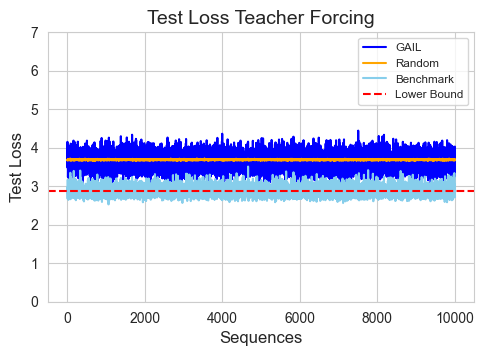

In [47]:
plt.figure(figsize=(5.5,3.5))
plt.plot(test_loss_gail, label='GAIL', color='blue')
plt.plot(test_loss_random, label='Random', color='orange')
plt.plot(test_loss_pretrain, label='Benchmark', color='skyblue')
plt.axhline(y=calculate_entropy(test_data.flatten()), color='r', linestyle='--', label='Lower Bound')
plt.xlabel('Sequences',fontsize=12)
plt.ylabel('Test Loss',fontsize=12)
plt.title('Test Loss Teacher Forcing', fontsize=14)
plt.legend(fontsize='small')
plt.ylim(0, 7)
#plt.savefig('Test_lossTFRandom.pdf', format='pdf', dpi=300)
plt.show()

In [51]:
kl_div = round(kl_divergence(test_data.flatten(), np.array(random_seq).flatten()),4)
js_div = round(calculate_js_divergence(test_data.flatten(), np.array(random_seq).flatten()),4)

print("KL Divergence between Real and Random Sequences (in bits):", kl_div)
print("JS Divergence between Real and Random Sequences (in bits):", js_div)
print('')

kl_div = round(kl_divergence(test_data.flatten(), np.array(gail_seq).flatten()),4)
js_div = round(calculate_js_divergence(test_data.flatten(), np.array(gail_seq).flatten()),4)

print("KL Divergence between Real and GAIL (in bits):", kl_div)
print("JS Divergence between Real and GAIL (in bits):", js_div)
print('')

kl_div = round(kl_divergence(test_data.flatten(), np.array(pretrain_seq).flatten()),4)
js_div = round(calculate_js_divergence(test_data.flatten(), np.array(pretrain_seq).flatten()),4)

print("KL Divergence between Real and Benchmark (in bits):", kl_div)
print("JS Divergence between Real and Becnhmark (in bits):", js_div)
print('')

KL Divergence between Real and Random Sequences (in bits): 1.1349
JS Divergence between Real and Random Sequences (in bits): 0.3148

KL Divergence between Real and GAIL (in bits): 0.8805
JS Divergence between Real and GAIL (in bits): 0.1914

KL Divergence between Real and Benchmark (in bits): 0.0016
JS Divergence between Real and Becnhmark (in bits): 0.0005



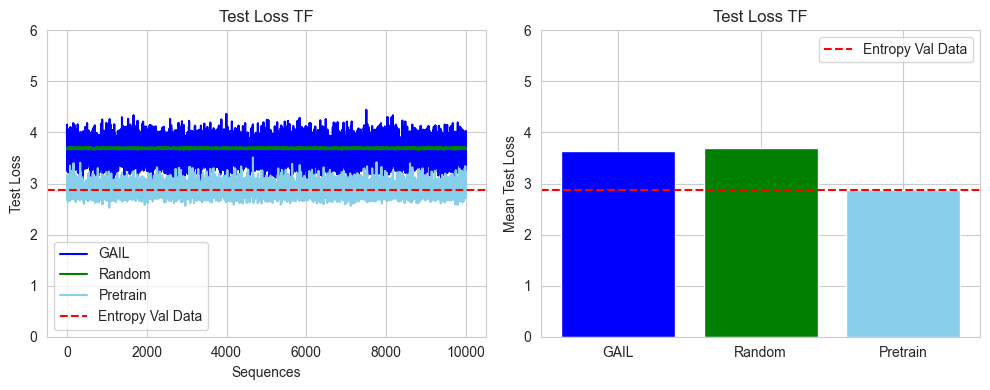

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(test_loss_gail, label='GAIL', color='blue')
ax1.plot(test_loss_random, label='Random', color='green')
ax1.plot(test_loss_pretrain, label='Pretrain', color='skyblue')
ax1.axhline(y=calculate_entropy(val_data.flatten()), color='r', linestyle='--', label='Entropy Val Data')
ax1.set_xlabel('Sequences')
ax1.set_ylabel('Test Loss')
ax1.set_title('Test Loss TF')
ax1.legend()
ax1.set_ylim(0, 6)

# Second plot: bar plot of mean validation loss
mean_values = [np.mean(test_loss_gail), np.mean(test_loss_random), np.mean(test_loss_pretrain)]
ax2.bar(['GAIL', 'Random', 'Pretrain'], mean_values, alpha=1, color=('blue', 'green', 'skyblue'))
ax2.axhline(y=calculate_entropy(val_data.flatten()), color='r', linestyle='--', label='Entropy Val Data')
ax2.set_ylabel('Mean Test Loss')
ax2.set_title('Test Loss TF')
ax2.legend()
ax2.set_ylim(0, 6)

plt.tight_layout()
plt.show()

In [54]:
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
random_means, random_variances, _, random_skew, _, _, _ = calculate_statistics(random_seq)
pretrained_means, pretrained_variances, _, pretrained_skew, _, _, _ = calculate_statistics(pretrain_seq)
gail_means, gail_variances, _, gail_skew, _, _, _ = calculate_statistics(gail_seq)

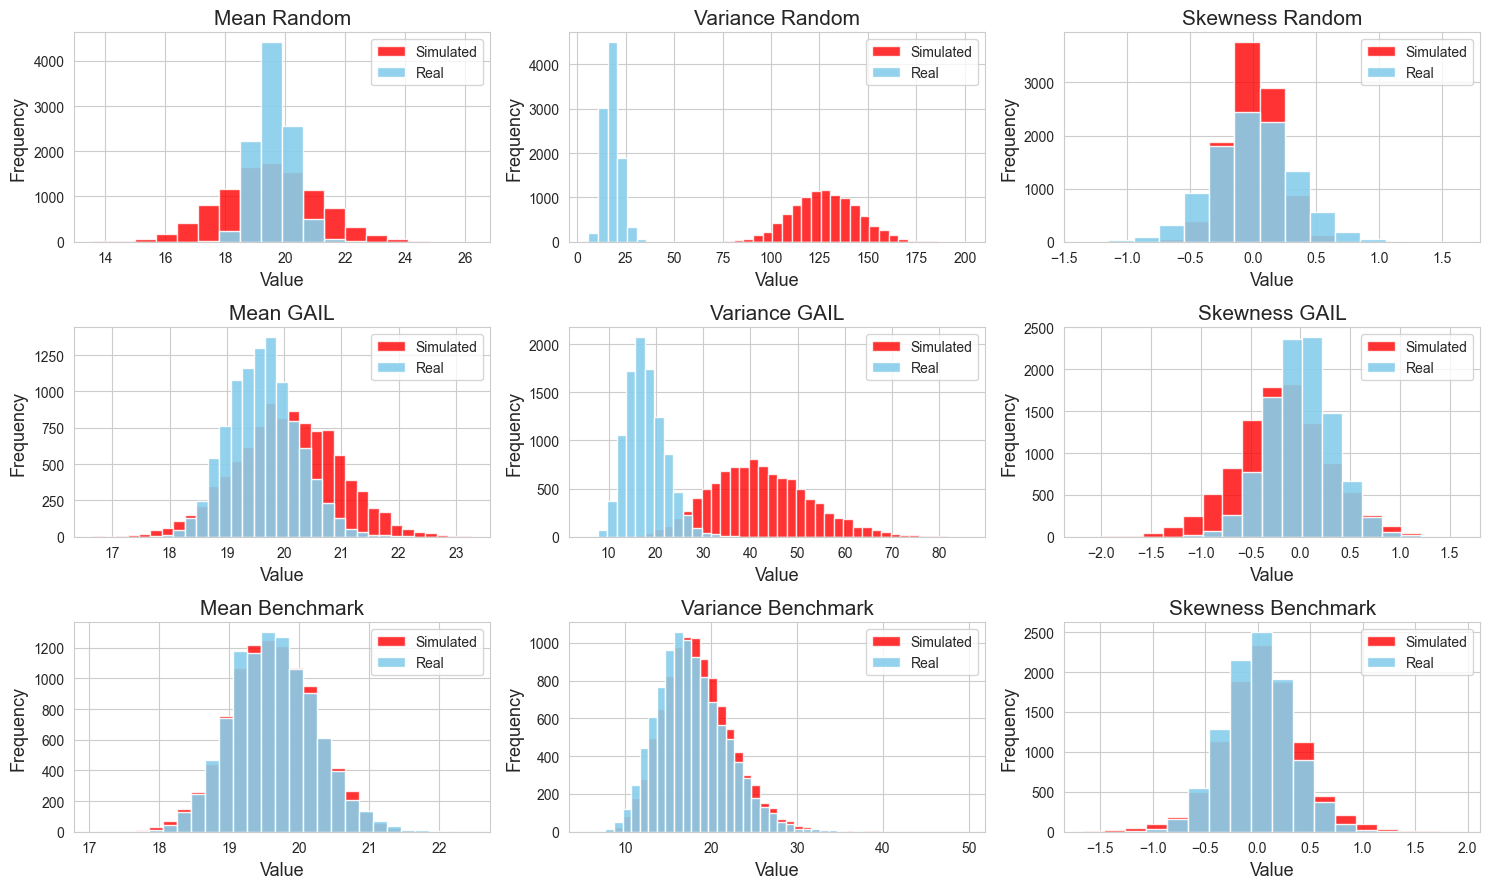

In [55]:
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
# Statistics for real and simulated trajectories

bin_start_mean = min(np.min(random_means), np.min(real_means))
bin_stop_mean = max(np.max(random_means), np.max(real_means))
bin_width_mean = 0.7
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_start_var = min(np.min(random_variances), np.min(real_variances))
bin_stop_var = max(np.max(random_variances), np.max(real_variances))
bin_width_var = 5
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_start_skew = min(np.min(random_skew), np.min(real_skew))
bin_stop_skew = max(np.max(random_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

# Plot 1: Mean Distribution
axs[0,0].hist(random_means,bins=bin_edges_mean,alpha=0.8, label='Simulated', color='red')
axs[0,0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0,0].legend(loc='upper right')
axs[0,0].set_title('Mean Random', fontsize=15)
axs[0,0].set_xlabel('Value', fontsize=13)
axs[0,0].set_ylabel('Frequency', fontsize=13)

# Plot 1: Variance Distribution
axs[0,1].hist(random_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[0,1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[0,1].legend(loc='upper right')
axs[0,1].set_title('Variance Random', fontsize=15)
axs[0,1].set_xlabel('Value', fontsize=13)
axs[0,1].set_ylabel('Frequency', fontsize=13)

# Plot 2: Skewness Distribution
axs[0,2].hist(random_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[0,2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[0,2].legend(loc='upper right')
axs[0,2].set_title('Skewness Random', fontsize=15)
axs[0,2].set_xlabel('Value', fontsize=13)
axs[0,2].set_ylabel('Frequency', fontsize=13)


bin_start_mean = min(np.min(gail_means), np.min(real_means))
bin_stop_mean = max(np.max(gail_means), np.max(real_means))
bin_width_mean = 0.2
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_start_var = min(np.min(gail_variances), np.min(real_variances))
bin_stop_var = max(np.max(gail_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_start_skew = min(np.min(gail_skew), np.min(real_skew))
bin_stop_skew = max(np.max(gail_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

# Plot 1: Mean Distribution
axs[1,0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[1,0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[1,0].legend(loc='upper right')
axs[1,0].set_title('Mean GAIL', fontsize=15)
axs[1,0].set_xlabel('Value', fontsize=13)
axs[1,0].set_ylabel('Frequency', fontsize=13)

# Plot 1: Variance Distribution
axs[1,1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1,1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1,1].legend(loc='upper right')
axs[1,1].set_title('Variance GAIL', fontsize=15)
axs[1,1].set_xlabel('Value', fontsize=13)
axs[1,1].set_ylabel('Frequency', fontsize=13)

# Plot 2: Skewness Distribution
axs[1,2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[1,2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[1,2].legend(loc='upper right')
axs[1,2].set_title('Skewness GAIL', fontsize=15)
axs[1,2].set_xlabel('Value', fontsize=13)
axs[1,2].set_ylabel('Frequency', fontsize=13)


bin_start_mean = min(np.min(pretrained_means), np.min(real_means))
bin_stop_mean = max(np.max(pretrained_means), np.max(real_means))
bin_width_mean = 0.2
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_start_var = min(np.min(pretrained_variances), np.min(real_variances))
bin_stop_var = max(np.max(pretrained_variances), np.max(real_variances))
bin_width_var = 1
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_start_skew = min(np.min(pretrained_skew), np.min(real_skew))
bin_stop_skew = max(np.max(pretrained_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

# Plot 1: Mean Distribution
axs[2,0].hist(pretrained_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[2,0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[2,0].legend(loc='upper right')
axs[2,0].set_title('Mean Benchmark', fontsize=15)
axs[2,0].set_xlabel('Value', fontsize=13)
axs[2,0].set_ylabel('Frequency', fontsize=13)

# Plot 1: Variance Distribution
axs[2,1].hist(pretrained_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[2,1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[2,1].legend(loc='upper right')
axs[2,1].set_title('Variance Benchmark', fontsize=15)
axs[2,1].set_xlabel('Value', fontsize=13)
axs[2,1].set_ylabel('Frequency', fontsize=13)

# Plot 2: Skewness Distribution
axs[2,2].hist(pretrained_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2,2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2,2].legend(loc='upper right')
axs[2,2].set_title('Skewness Benchmark', fontsize=15)
axs[2,2].set_xlabel('Value', fontsize=13)
axs[2,2].set_ylabel('Frequency', fontsize=13)
plt.tight_layout()
#plt.savefig('gail_random_moments.pdf', format='pdf', dpi=300)
plt.show()
